# Project 4
### Aminah Yizar

In [1]:
import folium
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
arrest_table = pd.read_csv("https://cmsc320.github.io/files/BPD_Arrests.csv")

arrest_table = arrest_table[pd.notnull(arrest_table["Location 1"])]

arrest_table["lat"], arrest_table["long"] = arrest_table["Location 1"].str.split(",").str
arrest_table["lat"] = arrest_table["lat"].str.replace("(", "").astype(float)
arrest_table["long"] = arrest_table["long"].str.replace(")", "").astype(float)

<ipython-input-2-fbbdd6b2cb6d>:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  arrest_table["lat"], arrest_table["long"] = arrest_table["Location 1"].str.split(",").str


In [25]:
arrest_table.head()

,arrest,age,race,sex,arrestDate,arrestTime,arrestLocation,incidentOffense,incidentLocation,charge,chargeDescription,district,post,neighborhood,Location 1,lat,long
1,11127013.0,37,B,M,01/01/2011,00:01:00,2000 Wilkens Ave,79-Other,Wilkens Av & S Payson St,1 1425,Reckless Endangerment || Hand Gun Violation,SOUTHERN,934.0,Carrollton Ridge,"(39.2814026274, -76.6483635135)",39.281403,-76.648364
2,11126887.0,46,B,M,01/01/2011,00:01:00,2800 Mayfield Ave,Unknown Offense,NaN,NaN,Unknown Charge,NORTHEASTERN,415.0,Belair-Edison,"(39.3227699160, -76.5735750473)",39.322770,-76.573575
3,11126873.0,50,B,M,01/01/2011,00:04:00,2100 Ashburton St,79-Other,2100 Ashburton St,1 1106,Reg Firearm:Illegal Possession || Hgv,WESTERN,735.0,Panway/Braddish Avenue,"(39.3117196723, -76.6623546313)",39.311720,-76.662355
4,11126968.0,33,B,M,01/01/2011,00:05:00,4000 Wilsby Ave,Unknown Offense,1700 Aliceanna St,NaN,Unknown Charge,NORTHERN,525.0,Pen Lucy,"(39.3382885254, -76.6045667070)",39.338289,-76.604567
5,11127041.0,41,B,M,01/01/2011,00:05:00,2900 Spellman Rd,81-Recovered Property,2900 Spelman Rd,1 1425,Reckless Endangerment || Handgun Violation,SOUTHERN,924.0,Cherry Hill,"(39.2449886230, -76.6273582432)",39.244989,-76.627358


As I was using the data, I realized that there is one and only one entry where the race and/or sex has a nan value. To make data usage easier, I replaced the race value for that entry with 'U,' as I am assuming this stands for 'Unidentified.' I also marked the nan value for sex with 'X'.

In [3]:
#print(arrest_table[arrest_table["sex"] != arrest_table["sex"]])
arrest_table['race'][49238] = 'U' # unidentified
arrest_table['sex'][49238] = 'X' # unidentified

<ipython-input-3-28f8548e3249>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrest_table['race'][49238] = 'U' # unidentified
<ipython-input-3-28f8548e3249>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrest_table['sex'][49238] = 'X' # unidentified


Because there are so many points in the table, and because many of them are practically on top of one another, it would not be very informative to simply place a marker at every arrest point on the map. Therefore, I decided to separate the data into chunks and investigate the information in each chunk. I ended up splitting the data by district, as they split the data locationally while still allowing for a diverse set of data to look through for each chunk.

In [4]:
# creates the list of DataFrames for the data from each police district, 
# as well as a DataFrame for arrests made outside of any documented district (nan values)
district_tables = []
for district in arrest_table["district"].dropna().unique():
    district_tables.append(arrest_table[arrest_table["district"] == district])
district_tables.append(arrest_table[arrest_table["district"] != arrest_table["district"]])

I also figured that it would be beneficial to find the most common offenses in each district. Since each district has many distinct arrest offenses, I decided to take the top 15 offenses from each district, as well as the total number of arrests made per district.

In [5]:
# creates a list of total arrests per district
# creates a list of the top 15 arrests per district
num_arrests = []
most_common = []
for district in district_tables:
    offenses = pd.Series(0)
    for offense in district["incidentOffense"].unique():
        offenses[offense] = len(district[district["incidentOffense"] == offense])
    offenses = offenses.sort_values(ascending=False)
    num_arrests.append(sum(offenses))
    most_common.append(offenses[0:15])

I wanted to display graphs of the data collected on the map, so I created 4 sets of graphs in total.

The first displays a bar graph of the number of arrests made for each common offense in each district. Unfortunately, the map further down cuts the x indices off due to the size of folium's tooltip, but they can be seen directly below this text. The most common offense by far in each district is the charge for Narcotics. After looking at the table, I found that this charge is associated with any involvement with narcotics, whether it is possession, manufacturing, distribution, or some other related offense.

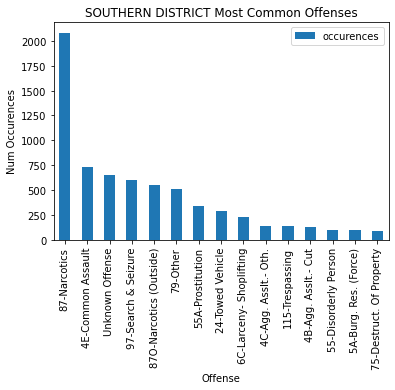

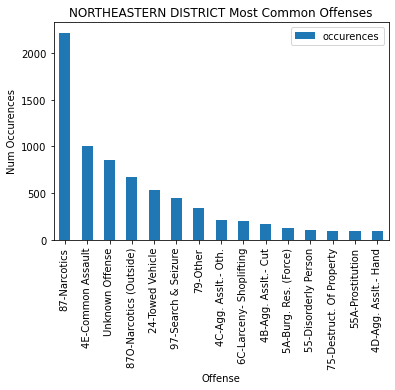

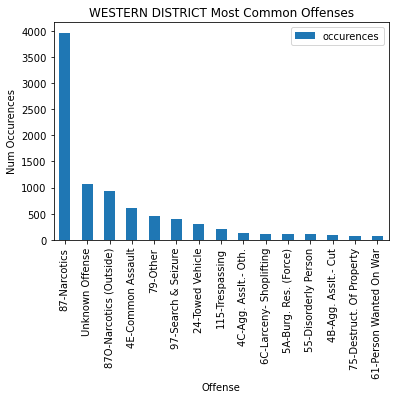

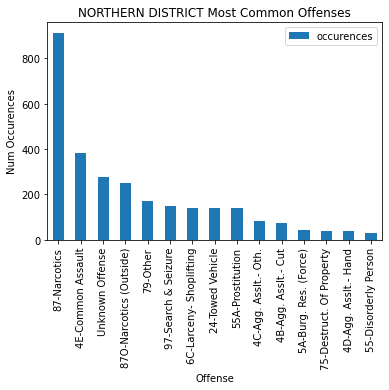

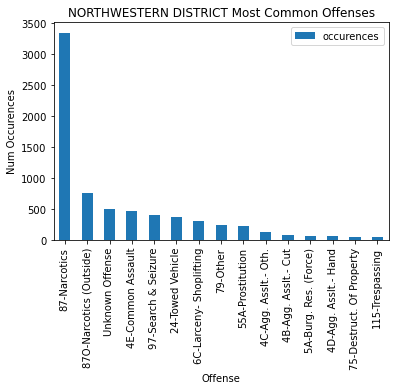

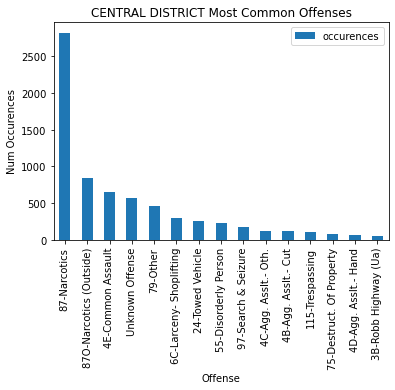

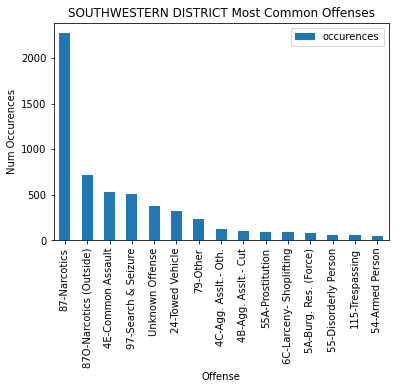

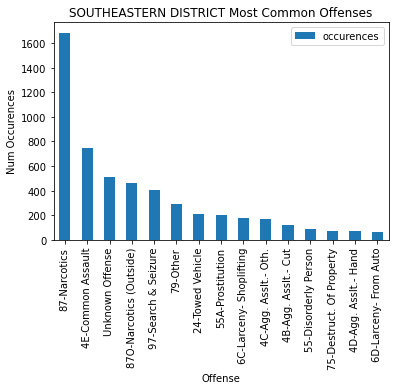

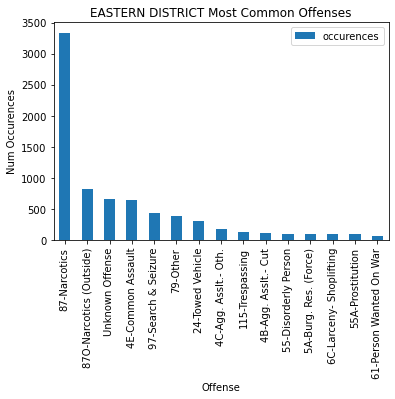

In [6]:
# creates a bar graph of the most common offenses per district
for i in np.arange(0, len(most_common) - 1):
        file_name = district_tables[i]['district'].values[0] + "_offenses.png"
        ax = pd.DataFrame(index=most_common[i].index, data={'offense':most_common[i].index, 'occurences':most_common[i].tolist()}).plot.bar()
        plt.title(district_tables[i]['district'].values[0] + " DISTRICT Most Common Offenses")
        plt.xlabel("Offense")
        plt.ylabel("Num Occurences")
        plt.savefig(file_name, format='png')
        plt.show()

The second set of graphs displays a boxplot of arrests by race and age per district. Almost every race has a normal/expected age range for arrest, between 16 (or a little younger) and 80. However there are some strange outliers. 

Many age entries in the tables are listed as Age 0, which obviously doesn't make sense (especially when looking at the charges listed). So, I dropped the entries where age was listed as 0 from the graph, essentially treating it as a nan value, since that is what those values were most likely intended to be (as int(np.nan) = 0).

However, even then there are some abnormally low ages. The lowest age apart from 0 is age 8, which also doesn't make much sense given the associated charges. I think this is an error, so I also dropped these values from the graph.

In regards to the resulting plots, black (B) and white (W) people have the largest ranges of age for arrest, in that order of largest to smallest for each graph. This makes sense since as we will see below, they also have the highest number of arrests, again in that order from most to least, in each district. There is only one documented hispanic (H) person in the entirety of the data we are given, so there is obviously no variance for that race. However, the other three races have varying age ranges of arrest per district.

Aside from the one hispanic person, the mean age is somewhere in between 20 and 40 for each race in each district.

range:30
range:70
range:43
range:44
range:59


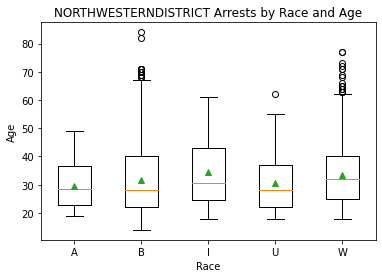

range:16
range:63
range:26
range:46
range:56


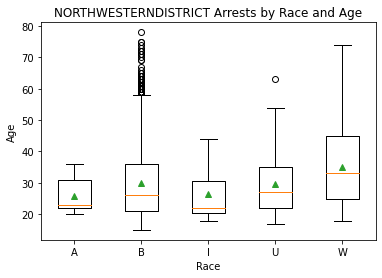

range:31
range:57
range:0
range:28
range:37
range:50


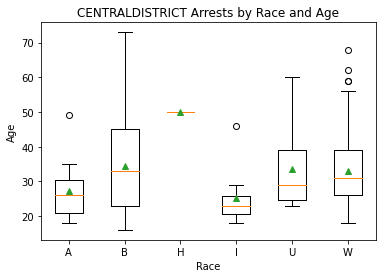

range:32
range:66
range:25
range:49
range:62


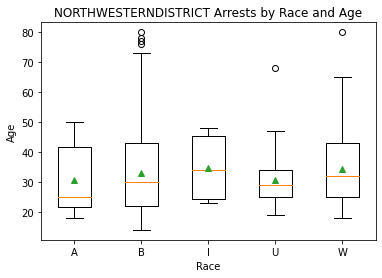

range:37
range:62
range:0
range:48
range:55


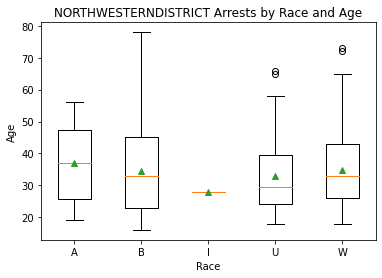

range:33
range:72
range:20
range:40
range:51


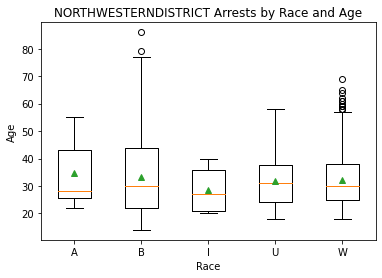

range:30
range:66
range:32
range:37
range:53


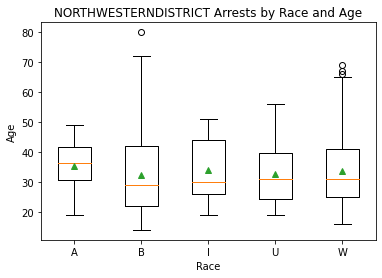

range:37
range:73
range:35
range:47
range:67


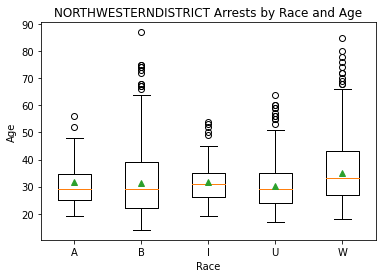

range:39
range:69
range:19
range:51
range:45


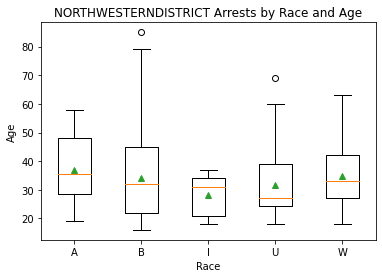

In [32]:
# creates boxplots of ages and races of arrest per district
for i in np.arange(0,9):
    temp = (district_tables[i][district_tables[i]['age']!=0])
    temp = temp[temp['age']!=8]
    races = sorted(temp['race'].unique())
    ages_per_race = [(temp[temp['race']==race])['age'].values.tolist() for race in races]
    
    ages_per_race = [(temp[temp['race']==race])['age'].values.tolist() for race in races]
    
    for i in np.arange(0, len(ages_per_race)):
        print("range:" + str(max(ages_per_race[i]) - min(ages_per_race[i])))
    
    file_name = temp['district'].values[0] + "_age_data.png"
    ax = plt.boxplot(ages_per_race, labels=races, showmeans=True)
    plt.xlabel("Race")
    plt.ylabel("Age")
    plt.title(district_tables[i]['district'].values[0] + "DISTRICT Arrests by Race and Age")
    plt.savefig(file_name, format='png')
    plt.show()

The third set are bar graphs depicting the number of arrests for every race and sex per district.

From the graphs, we can see that an overwhelming proportion of the arrests made in each district in Baltimore is of black men, with the next highest number of arrests being white men. However, the latter number is always much lower than the former.

SOUTHERN
      M    F  X
B  3947  747  0
W  1727  889  0
U   146   17  0
I    21    3  0
A    19    3  0


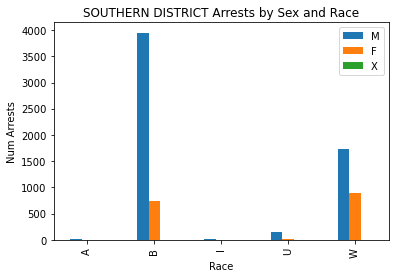

NORTHEASTERN
      M     F  X
B  5922  1082  0
W   593   213  0
U    83    12  0
A    13     2  0
I    13     2  0


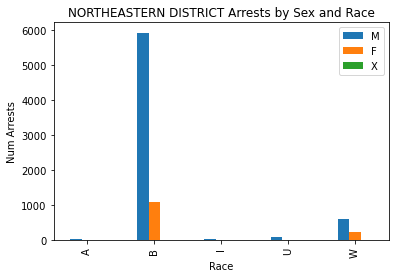

WESTERN
      M     F  X
B  7662  1308  0
W   285    82  0
I     8     2  0
U    25     3  0
A     8     4  0
H     1     0  0


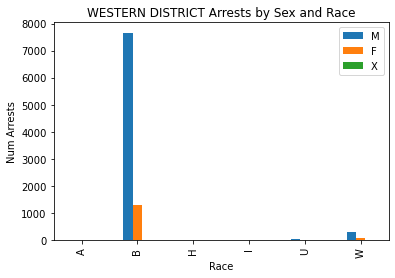

NORTHERN
      M    F  X
B  2396  435  0
W   329  149  0
A     8    0  0
U    23    6  0
I     3    3  0


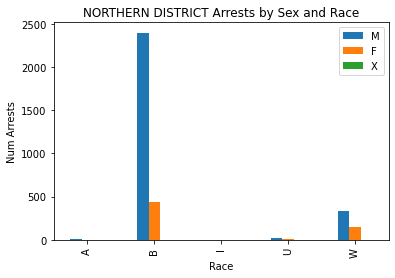

NORTHWESTERN
      M     F  X
B  5945  1251  0
W   215   125  0
U    42     8  1
A    14     2  0
I     1     0  0


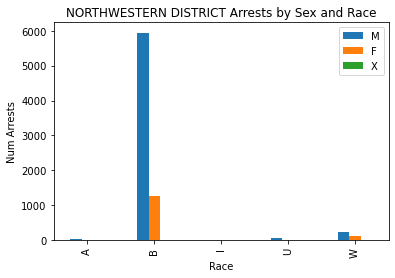

CENTRAL
      M     F  X
B  5435  1190  0
W   780   220  0
U    63    11  0
I     8     1  0
A     9     2  0


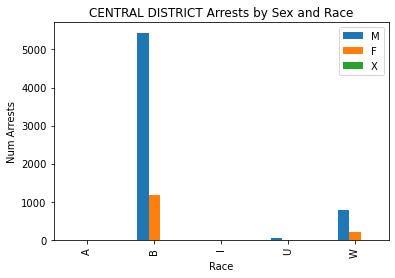

SOUTHWESTERN
      M    F  X
B  4587  752  0
W   567  228  0
A     6    0  0
U    38    8  0
I    11    0  0


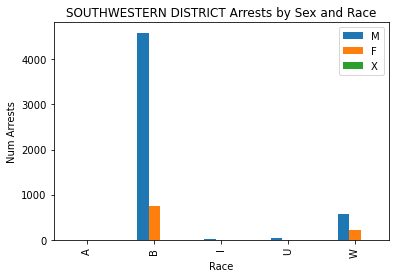

SOUTHEASTERN
      M    F  X
B  2895  546  0
A    35    4  0
W  1377  610  0
U   428   38  0
I    36    9  0


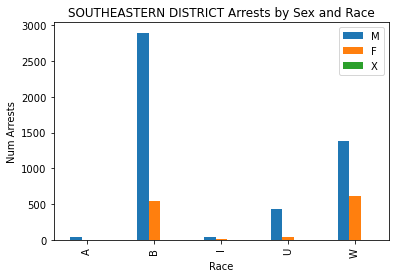

EASTERN
      M     F  X
B  6386  1259  0
W   272   117  0
U    41     5  0
I     6     3  0
A    15     5  0


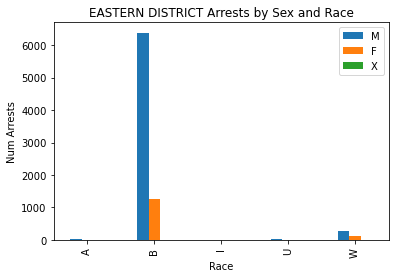

In [11]:
# creats bar graphs of the number of arrests for each race/sex
race_and_sex = []
for i in np.arange(0,9):
    race_and_sex.append(pd.DataFrame(index=district_tables[i]["race"].dropna().unique(), columns=['M','F','X'], data=0))
    
    for race in race_and_sex[i].index:
        all_sexes = district_tables[i][district_tables[i]["race"] == race]
        race_and_sex[i]['F'][race] = len(all_sexes[all_sexes['sex'] == 'F'].index)
        race_and_sex[i]['M'][race] = len(all_sexes[all_sexes['sex'] == 'M'].index)
        race_and_sex[i]['X'][race] = len(all_sexes[all_sexes['sex'] == 'X'].index)
    
    print(district_tables[i]['district'].values[0])    
    print(race_and_sex[i])
    
    file_name = district_tables[i]['district'].values[0] + "_data.png"
    ax = race_and_sex[i].sort_index().plot.bar()
    plt.xlabel('Race')
    plt.ylabel('Num Arrests')
    plt.title(district_tables[i]['district'].values[0] + " DISTRICT Arrests by Sex and Race")
    plt.savefig(file_name, format='png')
    plt.show()

The final set are scatterplots of the latitude and longitude, with each point colored differently depending on race. The result is a visual representation of the arrests made per district, as well as the proportion of the races arrested.

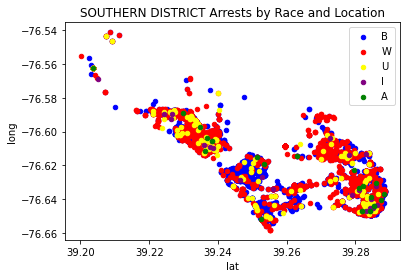

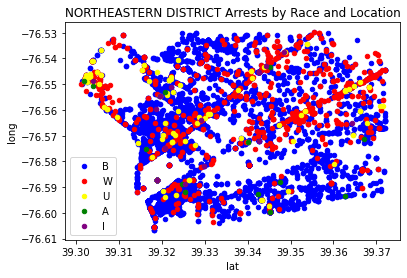

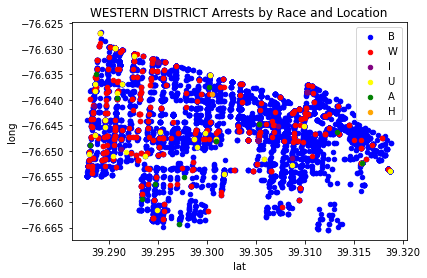

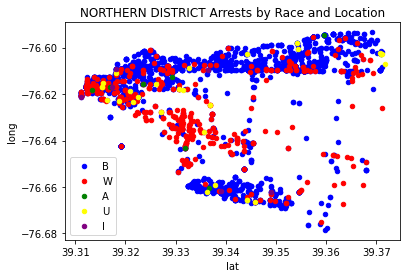

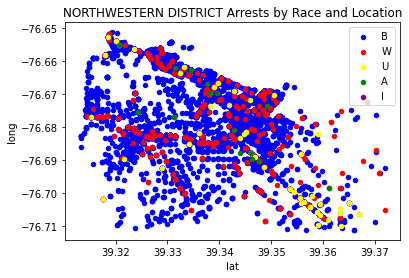

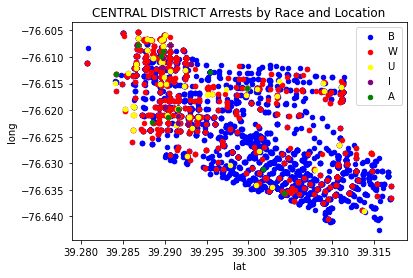

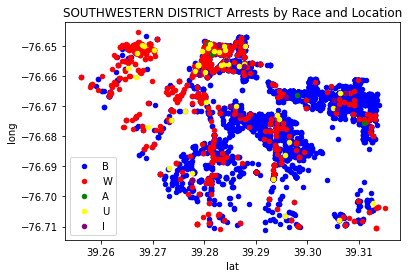

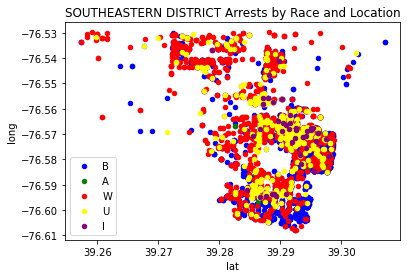

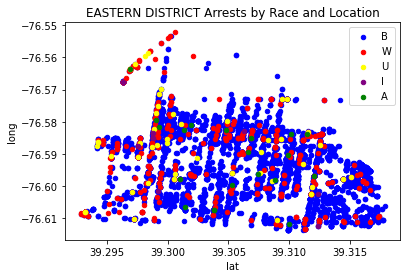

In [13]:
# the key for race -> color
color_codes = {'B':'blue', 'W':'red', 'U':'yellow', 'A':'green', 'I':'purple', 'H':'orange'}

# creates scatterplots of the location and races of each arrest in each district
for i in np.arange(0,9):
    file_name = district_tables[i]['district'].values[0] + ".png"
    
    fig, ax = plt.subplots()
    for race in district_tables[i]['race'].unique():
        temp = district_tables[i][district_tables[i]['race'] == race]
        
        temp.plot.scatter(x='lat', y='long',c=color_codes[race],label=race,ax=ax) 
    
    plt.legend()
    plt.title(district_tables[i]['district'].values[0] + " DISTRICT Arrests by Race and Location")
    plt.savefig(file_name, format='png')
    plt.show()

From the data collected, my conclusion is that:

A randomly chosen arrest made in Baltimore is more likely to be

1) Due to some narcotics offense

2) Of someone in their 20s-40s

3) Of a black man

independently.

-------------------------------------------------------------------------------------------------------------------------------

In [34]:
# creates an html table with the:
# District with the Most Arrests in Baltimore
# Most Common Offense in Baltimore
# Most Arrested Race in Baltimore
# Most Arrested Sex in Baltimore
# Mean Arrested Age in Baltimore

overall_info = ''

overall_info += '<table style="width:100%">\n'
overall_info += '\t<tr>\n'
#overall_info += '\t\t<td><sup>Most Arrests</sup></td>\n'
overall_info += '\t\t<td><sup>Most Common Offense</sup></td>\n'
overall_info += '\t\t<td><sup>Most Arrested Race</sup></td>\n'
overall_info += '\t\t<td><sup>Most Arrested Sex</sup></td>\n'
overall_info += '\t\t<td><sup>Mean Arrested Age</sup></td>\n'
overall_info += '\t</tr>\n'
overall_info += '\t<tr>\n'
#overall_info += '\t\t<td><small>Western District</small></td>\n'
overall_info += '\t\t<td><small>87-Narcotics</small></td>\n'
overall_info += '\t\t<td><small>B</small></td>\n'
overall_info += '\t\t<td><small>M</small></td>\n'
overall_info += '\t\t<td><small>' + str(int(arrest_table['age'].mean())) + '</small></td>\n'
overall_info += '\t</tr>\n'
overall_info += '\t</table>\n'

In [35]:
# creates the map
map_osm = folium.Map(location=[39.29, -76.61], zoom_start=11)

In [36]:
# creates the outer circle, which displays the overall information written in the html table above when clicked
# as well as the total number of arrests in Baltimore when scrolled over
folium.Circle(
    location=[arrest_table['lat'].median(), arrest_table['long'].median()],
    radius=12000,
    color='red',
    fill=False,
    popup = folium.Popup(html=overall_info),
    tooltip = 'Total Arrests:' + str(sum(num_arrests))
).add_to(map_osm)

In [37]:
# creates markers for each district, which display the graph for the most common offenses in the district when scrolled over
# and the other three graphs displaying the demographics of arrest when clicked
for i in np.arange(0,9):
    district = district_tables[i]
    center_lat = district['lat'].median()
    center_long = district['long'].median()
    max_lat = district['lat'].max()
    max_long = district['long'].max()
    district_name = district['district'].values[0]
    
    tooltip = "<img src='" + district_name + "_offenses.png'>\nTotal Arrests:" + str(num_arrests[i])
    text = district['district'][district.index.values[0]] + "\n"
    
    for race in district["race"].dropna().unique():
        text += race + ":" + str(len(district[district["race"] == race].index)) + "\n"
    
    folium.Circle(
        location=[center_lat, center_long],
        radius = 1000,
        popup = folium.Popup(html="<img src='" + district_name + "_age_data.png'>\n<img src='" + district_name + "_data.png'>\n<img src='" + district_name + ".png'>"),
        tooltip = tooltip,
        color = '#3186cc',
        fill = True,
        fill_color = '#3186cc'
    ).add_to(map_osm)

In [38]:
# displays individual markers for each arrest not in a documented district ('nan' district)
# each marker displays the offense when scrolled over and the sex, age, and race of the person arrested when clicked
for i in district_tables[9].index.values:
    lat = district_tables[9]['lat'][i]
    long = district_tables[9]['long'][i]
    text = "<i>Race:" + district_tables[9]['race'][i] 
    text += "\nSex:" + district_tables[9]['sex'][i] 
    text += "\nAge:" + str(district_tables[9]['age'][i]) + "</i>"
    tooltip = "<b>Offense:" + str(district_tables[9]['incidentOffense'][i]) + '</b>'
    
    
    folium.Marker(
        location = [lat, long],
        popup = text,
        tooltip = tooltip
    ).add_to(map_osm)

-------------------------------------------------------------------------------------------------------------------------------

### Guide

#### Large Red Circle
This is essentially the tl;dr of the map. 

Scrolling over will show the total arrests made in Baltimore. 

Clicking will show a table of the Most Common Offense made, Most Commonly Arrested Race, Most Commonly Arrested Sex, and the Mean Arrested Age.

#### Small Blue Circles
These contain data for each individual district.

Scrolling over will show the bar graph for the 15 most common offenses in the district, as well as how many arrests were made in total in the district.

Clicking will show the demographics for arrest in the district. The boxplot shows the distribution of age of arrest per race in the district. The bar graph shows the distribution of sex and race (combined) of arrest in each district. The scatter plot shows the location via longitude and latitude of each arrest, as well as the race of the person arrested.

*Note: the full popup is large, but can be viewed by dragging up/down in the map*

#### Blue Pointers
These represent arrests made outside of any documented district.

Scrolling over will show the offense of the person arrested.

Clicking will show the race, sex, and age of the person arrested.

In [39]:
map_osm